# The Movies Dataset

<div align="left">
<a href="https://github.com/madewithml/incubator/blob/master/datasets/movies/data.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/incubator/blob/master/movies/data.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

## Download

Download the data from the source to your file system so you can start exploring it. The official dataset is located [here](https://www.kaggle.com/rounakbanik/the-movies-dataset/data) but we **highly** recommend using our slightly cleaned version [here](https://drive.google.com/drive/folders/1ZGp7ORu9nA6l3PyNK_H0MGTXNl4sNMsA?usp=sharing) (where we combined movies, keywords and credits into one DataFrame).

We didn't do much preprocessing (because we want you to learn how to do that) but we did make sure the data formats are easier to handle etc. as the original dataset is a bit unconventionally stored (ex. they had a string of lists of dicts as values in a Pandas Dataframe which is hopefully something you never see in the real world).

## Features

Some light feature exploration on the different data CSVs.

In [143]:
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import os
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import wordcloud, STOPWORDS 
import glob
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import scipy.sparse as sp

In [24]:
warnings.filterwarnings("ignore")

### Movies

Rich metadata about each movie including it's title, description, genres, etc.

In [25]:
# Load movies
movies = pd.read_csv('/Users/davidshi/Downloads/movie/movies.csv', header=0)
movies = movies.replace({np.nan: None}) # replace NaN with None
movies.head()

,id,title,tagline,description,genres,keywords,date,collection,runtime,revenue,...,director,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url
0,862,Toy Story,None,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family","jealousy, toy, boy, friendship, friends, rival...",1995-10-30,Toy Story Collection,81,3.73554e+08,...,John Lasseter,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",Pixar Animation Studios,United States of America,21.9469,7.7,5415,en,tt0114709,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,8844,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family","board game, disappearance, based on children's...",1995-12-15,None,104,2.62797e+08,...,Joe Johnston,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","TriStar Pictures, Teitler Film, Interscope Com...",United States of America,17.0155,6.9,2413,en,tt0113497,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2,15602,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"romance, comedy","fishing, best friend, duringcreditsstinger, ol...",1995-12-22,Grumpy Old Men Collection,101,0,...,Howard Deutch,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Warner Bros., Lancaster Gate",United States of America,11.7129,6.5,92,en,tt0113228,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3,31357,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","comedy, drama, romance","based on novel, interracial relationship, sing...",1995-12-22,None,127,8.14522e+07,...,Forest Whitaker,"Whitney Houston, Angela Bassett, Loretta Devin...",Twentieth Century Fox Film Corporation,United States of America,3.85949,6.1,34,en,tt0114885,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4,11862,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,comedy,"baby, midlife crisis, confidence, aging, daugh...",1995-02-10,Father of the Bride Collection,106,7.65789e+07,...,Charles Shyer,"Steve Martin, Diane Keaton, Martin Short, Kimb...","Sandollar Productions, Touchstone Pictures",United States of America,8.38752,5.7,173,en,tt0113041,/e64sOI48hQXyru7naBFyssKFxVd.jpg


In [26]:
# Total
print (f"{len(movies)} movies in total.")

46628 movies in total.


total of 20 unique genres from 93342 occurances.


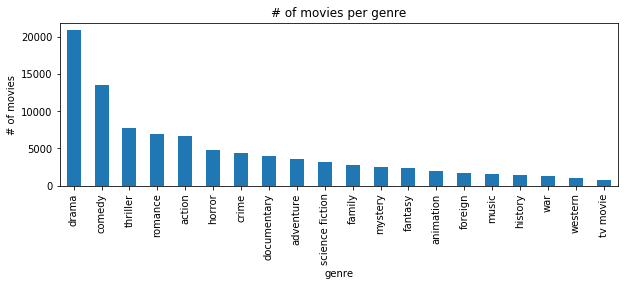

In [27]:
# Genres
all_genres = [s.split(", ") for s in movies[movies.genres.notnull()].genres]
genres = [item for l in all_genres for item in l ]
unique_genres = set(genres)
print (f"total of {len(unique_genres)} unique genres from {len(genres)} occurances.")
pd.Series(genres).value_counts().plot(kind='bar', figsize=(10, 3))
plt.title("# of movies per genre")
plt.ylabel("# of movies")
plt.xlabel("genre")
plt.show()

In [28]:
def get_year(date):
    year = None
    if date:
        year = date[:4]
    return year

In [29]:
# Year (example of basic feature engineering)
movies['year'] = movies.date.apply(get_year) # same as movies.date.apply(lambda date: get_year(date))

Total of 135 uinque years from 1874 to 2020


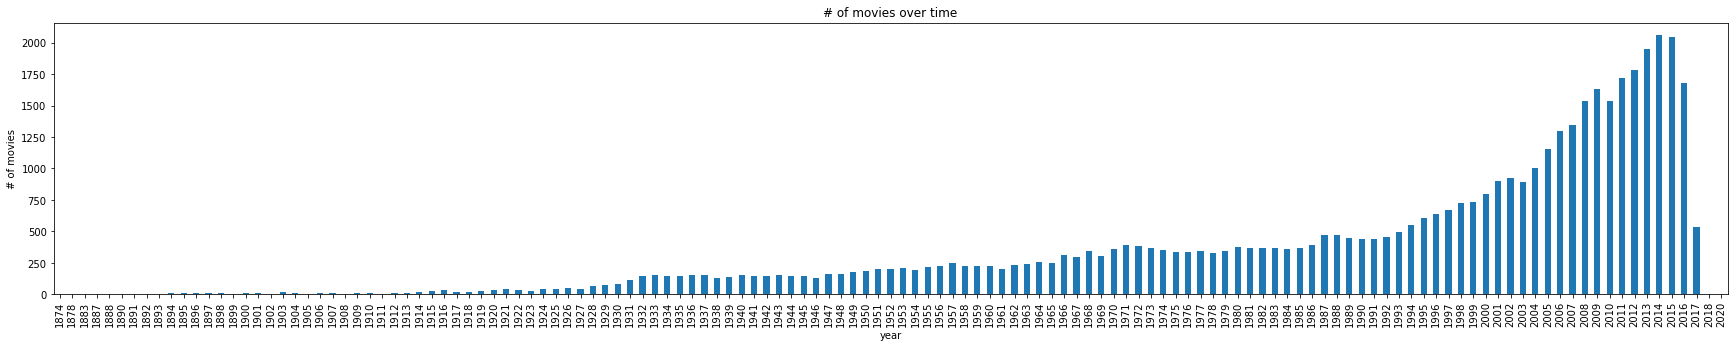

In [30]:
# Years
years = movies[movies.year.notnull()].year # get rows where year is not None
print (f"Total of {len(set(years))} uinque years from {min(years)} to {max(years)}")
pd.Series(years).value_counts().sort_index().plot(kind='bar', figsize=(30, 5))
plt.title("# of movies over time")
plt.ylabel("# of movies")
plt.xlabel("year")
plt.show()

In [31]:
# Sort by popularity
sorted_by_popularity = movies.sort_values(by='popularity', ascending=False)
print ("Most popular movies:\n", sorted_by_popularity['title'].values[:10])

Most popular movies:
 ['Minions' 'Wonder Woman' 'Beauty and the Beast' 'Baby Driver'
 'Big Hero 6' 'Deadpool' 'Guardians of the Galaxy Vol. 2' 'Avatar'
 'John Wick' 'Gone Girl']


In [32]:
# Get poster image
from IPython.core.display import display, HTML
prefix_url = 'http://image.tmdb.org/t/p/'
poster_sizes = ["w92", "w154", "w185", "w342", "w500", "w780", "original"]
full_url = prefix_url + poster_sizes[2] + movies.poster_url[0]
display(HTML(f'<img src="{full_url}">'))

### Ratings

User ratings for each movie. We are using the smaller set of ratings (subset of 100,000 ratings from 700 users on 9,000 movies.) but you can download the full version (26 million ratings from 270,000 users for all 45,000 movies) from the [source](https://www.kaggle.com/rounakbanik/the-movies-dataset/data). 

In [33]:
# Load ratings
ratings = pd.read_csv("/Users/davidshi/Downloads/movie/ratings_small.csv", header=0)
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


The first row in the dataframe above can be read as the following: userId `1` voted `2.5` on movieId `31` at timestamp `1260759144`.

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


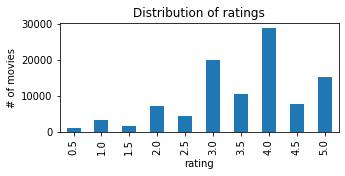

In [34]:
# Distribution of ratings
print (ratings['rating'].describe())
pd.Series(ratings['rating']).value_counts().sort_index().plot(kind='bar', figsize=(5, 2))
plt.title("Distribution of ratings")
plt.ylabel("# of movies")
plt.xlabel("rating")
plt.show()

## Project ideas

Details and resources for different project directions using this dataset. When you're developing your models, start with simple approaches first and then slowly add complexity. You should clearly document (README, articles and [Weights and Biases reports](https://www.youtube.com/watch?v=o2dOSIDDr1w)) and save your progression from simple to more complex models so your audience can see the improvements. The ability to write well and document your thinking process is a core skill to have in research and industry.

- **Moderate Projects** 

    - **[Exploratory analysis](https://madewithml.com/projects/160/programming-probabilistically/)**: relationships between staff/revenue, popularity/genre, etc. These could be simple statistical tests to validate some hypothesis (ex. action movies get better ratings than horror movies). This project can also involve a lot of exploratory analysis. 
        - People should not dismiss this project because this kind of statistical analysis is **very prevalent** in the industry. Not everything is about using deep learning to predict classes and it's kind of analysis that many marketing, advertising, science, etc. industries utilize every day to make their decisions.

    - **[Text classification](https://madewithml.com/topics/text-classification/)**: multi-class classification of movie genres using title, ratings, etc. You can also be very creative here and try to get more metadata like movie descriptions from online using the ids provided in the dataset.
        - When you're developing your models, start with simple approaches first and then slowly add complexity. For example, start with analyzing the text as tokens and using [logistic regression](https://madewithml.com/topics/logistic-regression/). Then explore [embeddings](https://madewithml.com/topics/embeddings/) with [CNNs](https://madewithml.com/topics/convolutional-neural-networks/) and [RNNs](https://madewithml.com/topics/recurrent-neural-networks/) and eventually attempt to use contextualized embeddings, pretrained [Transformers](https://madewithml.com/topics/transformers/) from [HuggingFace](https://madewithml.com/search-results/?tags=huggingface), etc.

    - **Miscellaneous**: predict numerical statistics like revenue, popularity, etc. given title, genre, production companies, etc. Here you can start with simple models like [linear regression]() and then try out ensemble methods like [random forests]() and evetually use neural networks. If you have time, you can even explore more recent methods that offer the performance of large networks with the interpretability of simples models - for example: [TabNet](https://madewithml.com/projects/1001/tabnet-attentive-interpretable-tabular-learning/) or [Neural Backed Decision Trees](https://madewithml.com/projects/659/neural-backed-decision-trees/).

- **Challenging projects**
    - [**Recommendation systems**](https://madewithml.com/topics/recommendation-systems/): recommend a movie based on liked movies. There are a lot of different approaches here but the most common technique will be content based. Ask the user to select movies that they like (from the dataset) and then recommend similar movies (based on genres, ratings, cast, crew, etc.) that they'd enjoy. 

    - [**Text generation**](https://madewithml.com/topics/text-generation/): generate the `tagline` or `overview` from movie title, genre, poster image, etc. or vice versa. You should definitely leverage pretrained language models here and then you can fine-tune using text from this dataset. 

    - [**Named entity recognition**](https://madewithml.com/topics/named-entity-recognition/): identify entities in movie titles and descriptions. This dataset doesn't come with any labeled entities however you can use a trained NER model to extract relevant entites that model can handle. This isn't much of an application so if you do choose this project, we suggest extending this to things like few-shot NER using embeddings, etc.

    - [**Few-shot learning**](https://madewithml.com/topics/few-shot-learning/): identify genres using one or just a few samples, also check out [self-supervision](https://madewithml.com/search-results/?tags=self-supervised-learning&tags=natural-language-processing) techniques in NLP where you can create meaningful tasks with the data that extract relevant signal from the latent space which can then be used for classification with very few samples. 

---
Learn, explore and build at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.youtube.com/channel/UCaVCnFQXS7PYMoYZu3KdC0Q?sub_confirmation=1"><img src="https://img.shields.io/badge/style--5eba00.svg?label=YouTube&logo=youtube&style=social"></a>&nbsp;<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             

In [35]:
movies.isnull().sum()

id                          0
title                       4
tagline                 25845
description               995
genres                   2524
keywords                14889
date                       88
collection              42054
runtime                   268
revenue                     4
budget                      0
director                  917
cast                     2491
production_companies    12282
production_countries     6496
popularity                  4
average_vote                4
num_votes                   4
language                   11
imdb_id                    17
poster_url                399
year                       88
dtype: int64

In [36]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 22 columns):
id                      46628 non-null int64
title                   46624 non-null object
tagline                 20783 non-null object
description             45633 non-null object
genres                  44104 non-null object
keywords                31739 non-null object
date                    46540 non-null object
collection              4574 non-null object
runtime                 46360 non-null object
revenue                 46624 non-null object
budget                  46628 non-null int64
director                45711 non-null object
cast                    44137 non-null object
production_companies    34346 non-null object
production_countries    40132 non-null object
popularity              46624 non-null object
average_vote            46624 non-null object
num_votes               46624 non-null object
language                46617 non-null object
imdb_id             

making a dataframe copy of movies so we can manipulate without crying about mistakes

In [37]:
df=movies

**Revenue vs Ratings** 

Comparing the relationship between revenue generated and ratings. Although data already provides average rating, this can be quite misleading. When comparing two average ratings the consideration of number of votes is very important. Movie 1 can have a rating of 9.0 with only 3 votes compared to Movie 2 having a rating of 8.0 with 50 votes. In this situation Movie 1's rating is very biased due to the low amount of voters. To tackle this problem IMBD have a weight rating formula.

Weighted Rating = (vR)/(v+m) + (mC)/(v+m)

m = minimum votes to be listed in chart ( we will assume movies with 85 percentile number of voters to be relevant)  
C = mean of average rating for all movies  
R = average rating for specific movie  
v = number of votes for specific movie


In [38]:
m=df['num_votes'].quantile(0.85)

In [39]:
C=df['average_vote'].mean()

In [40]:
df2=df[df['num_votes']>m]

In [41]:
def weightedrating(j,m=m,C=C):
    v=j['num_votes']
    R=j['average_vote']
    
    return (v*R)/(v+m) + (m*C)/(v+m)

In [42]:
df2['weighted_rating']=df2.apply(weightedrating,axis=1)

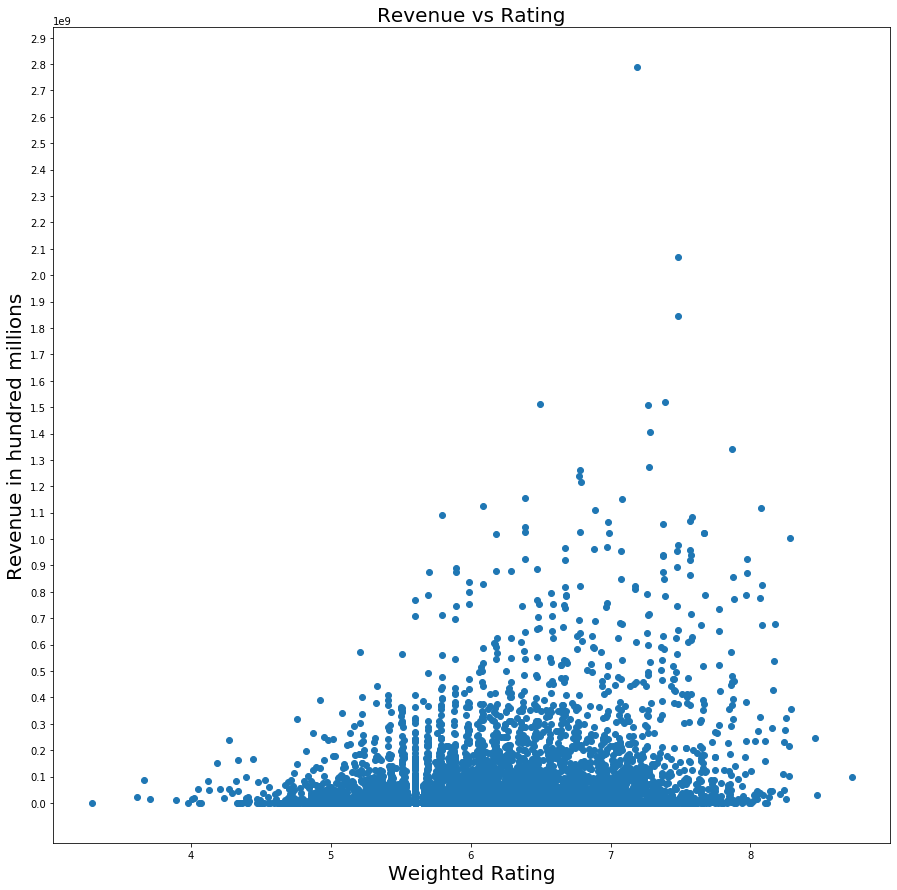

In [43]:
plt.figure(figsize=(15,15))
plt.xlabel('Weighted Rating', fontsize=20)
plt.ylabel('Revenue in hundred millions',fontsize=20)
plt.yticks(np.arange(0, 3000000000, 100000000))
plt.title('Revenue vs Rating', fontsize=20)
plt.scatter(x='weighted_rating',y='revenue',data=df2)

From this graph we can interpret high rating movies have a chance of high revenue compared to low rating movies. However most movies are below 50 million in revenue regardless of rating

**Profit distribution**  

I will plot the profit distribution plot to analyze disparity of profit. Profit is estimated by revenue - budget

In [44]:
prof = pd.Series(df2['revenue']-df2['budget'])

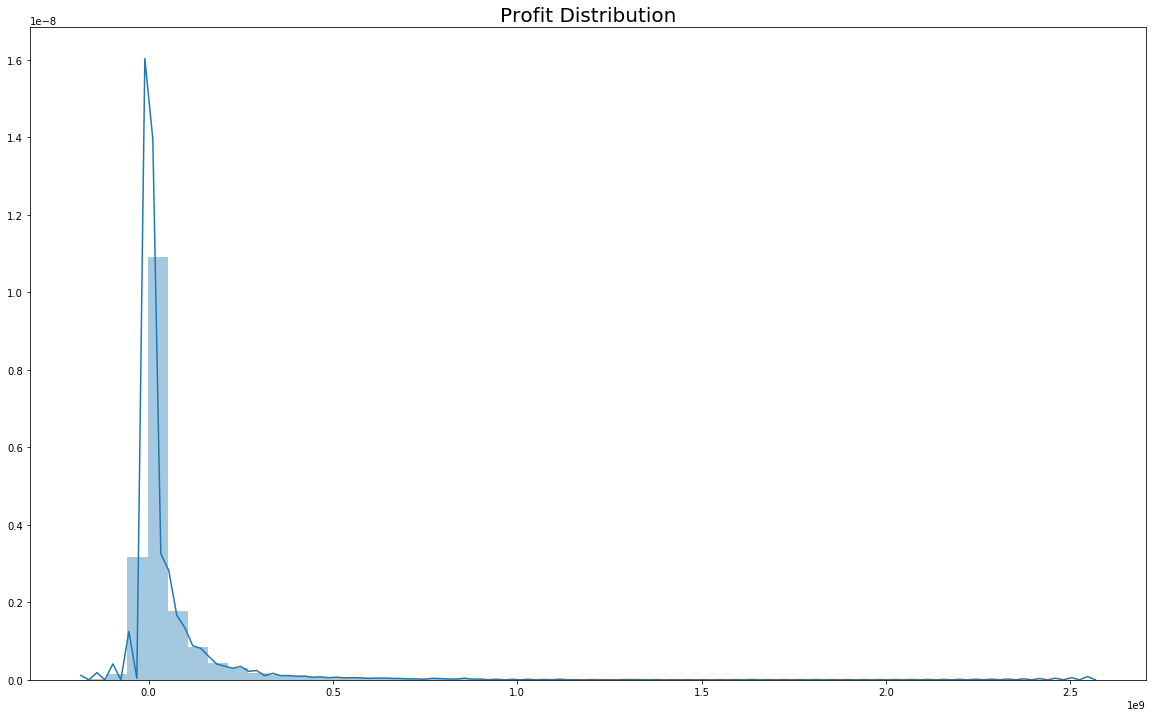

In [45]:
plt.figure(figsize=(20,12))
plt.title('Profit Distribution', fontsize=20)
sns.distplot(prof);

distribution plot is extremely right skewed

**Production Country Analysis**  

The product_countries column is hard to work with in the original data. Currently if the movie is produced in multiple countries it is a string of text which is hard to interpret. Example current value would be 'turkey, china'. I want to split this string into a list of seperate strings of country.

'turkey, china' ---> ['turkey' , 'china']

This process would make the column more analyzable

In [46]:
df['production_countries']=df['production_countries'].astype(str)

In [47]:
x=0
pdlist=[]
for i in df['production_countries']:
    df.production_countries[x]=df.production_countries[x].split(', ')
    pdlist=pdlist+df.production_countries[x]
    x=x+1

In [48]:
temp=pd.Series(pdlist).value_counts()

In [49]:
temp.head(30)

United States of America    21484
None                         6496
United Kingdom               4186
France                       4079
Germany                      2324
Italy                        2240
Canada                       1795
Japan                        1726
Spain                         982
Russia                        924
India                         868
Sweden                        604
Hong Kong                     600
Australia                     579
South Korea                   532
Belgium                       505
Finland                       415
Denmark                       406
China                         390
Netherlands                   390
Mexico                        343
Poland                        341
Brazil                        305
Argentina                     266
Switzerland                   258
Ireland                       225
Norway                        216
Austria                       214
Czech Republic                210
Hungary       

From this quick snippet of the list of top movie production countries, United of State of America dominates heavily.

**Genre Ratings**

I want to find the average rating by genre. I add the 'average_vote' column according to genre and divide by total amount of movies in that genre. Movies with multiple genre will be counted multiple times in those specific genres. The biggest trick here is to loop through the dataframe and the list within the 'genre' column to capture the mulitple genres a movie falls within.

In [50]:
df=df[~df['genres'].isnull()]
df=df[~df['average_vote'].isnull()]
df['genres']=df['genres'].str.split(', ')

In [51]:
genre_avgvote = pd.DataFrame(columns=['genre','avgvote'])
for x in unique_genres:
    count = 0
    totalrating = 0
    i = 0
    while (i<len(df)):
        j=0
        if not df.iloc[i,4]:
            i=i+1
            
        else:
            while (j<len(df.iloc[i,4])):
               if(df.iloc[i,4][j]==x):
                    count=count+1
                    totalrating = totalrating + df.iloc[i,16]
               j=j+1
        i=i+1
            
        
    genre_avgvote=genre_avgvote.append({'genre':x,'avgvote':(totalrating/count)},ignore_index=True)
    

,genre,avgvote
0,mystery,5.824085
1,western,5.134278
2,fantasy,5.762348
3,family,5.746556
4,war,6.036573
5,science fiction,5.336978
6,comedy,5.708577
7,foreign,5.750387
8,animation,6.271407
9,horror,5.225084


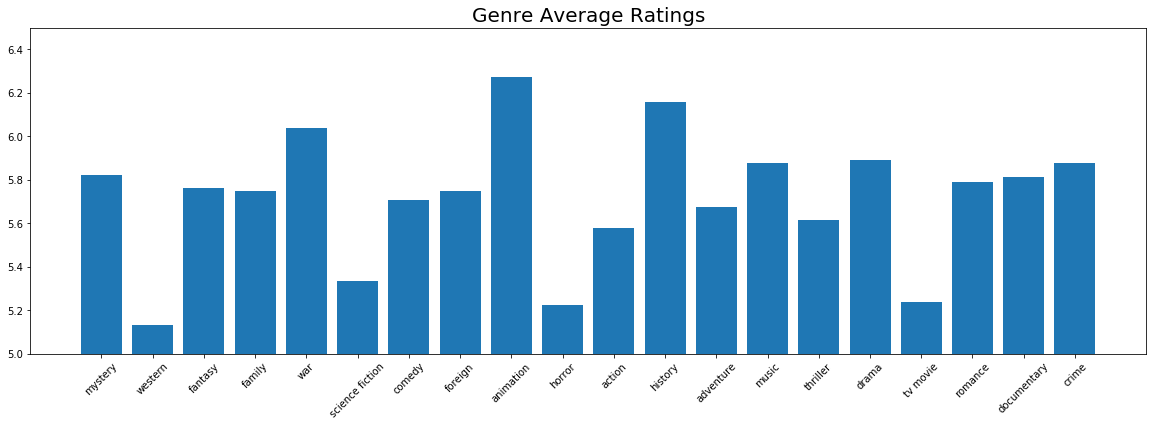

In [52]:
plt.figure(figsize=(20,6))
plt.ylim(5,6.5)
plt.xticks(rotation=45)
plt.bar('genre','avgvote',data=genre_avgvote)
plt.title('Genre Average Ratings', fontsize=20)
genre_avgvote

From this breakdown we can take away  

science fiction / TV movie / western / horror have have the lowest average ratings  
war / history / animation have high average ratings

**Predictive Analysis on Rating**  

I will try to use TF-IDF to create sparse matrix on text features to predict rating. I wonder if description of movies can predict rating. Most likely we will not find any strong results, however I will try it for learning purposes. Randomforest regression is my choice of regression since I believe it is the most complex one which suites this situation.

In [53]:
df3=movies

In [54]:
df3=df3[~df3['description'].isnull()]
df3=df3[~df3['average_vote'].isnull()]

In [55]:
def cleanstring(x):
    
    x = x.translate(str.maketrans('', '', string.punctuation))
    x = [c for c in x.split() if c.lower() not in stopwords.words('english')]
    return " ".join(x)

In [56]:
df3['description']=df3['description'].apply(cleanstring)

In [57]:
X=TfidfVectorizer("english").fit_transform(df3['description'])

In [58]:
y=df3['average_vote']

In [59]:
df3['average_vote']=pd.to_numeric(df3['average_vote'])

In [60]:
 X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=0)

In [61]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
rf_ypred=rf.predict(X_test)

In [62]:
def measurements(ytest,ypred):
    x=rf_mse = mean_squared_error(ytest, ypred)
    y=rf_mae = mean_absolute_error(ytest, ypred)
    z=rf_r2=r2_score(ytest,ypred)
    print('MSE:' + str(x))
    print('MAE:' + str(y))
    print('r2:' + str(z))

In [63]:
print(measurements(y_test,rf_ypred))

MSE:3.905757638119015
MAE:1.3536621165248657
r2:-0.06652987878643035
None


well just as I predicted our rating prediction using randomforest is absolutely useless. We got a negative R-squared which means the average of y variable is a better prediction then the regression.

**Recommendation by Genre**  

Function to list top 20 movies in filtered by Genre  

- order by imbd weighted rating  
- order by popularity
- order by average vote


In [64]:
df4=movies
df4=df4[~df4['genres'].isnull()]
df4['genres']=df4['genres'].str.split(', ')

In [65]:
df4.set_index('id')

,title,tagline,description,genres,keywords,date,collection,runtime,revenue,budget,...,cast,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url,year
id,,,,,,,,,,,,,,,,,,,,,
862,Toy Story,None,"Led by Woody, Andy's toys live happily in his ...","[animation, comedy, family]","jealousy, toy, boy, friendship, friends, rival...",1995-10-30,Toy Story Collection,81,3.73554e+08,30000000,...,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...",Pixar Animation Studios,[United States of America],21.9469,7.7,5415,en,tt0114709,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995
8844,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[adventure, fantasy, family]","board game, disappearance, based on children's...",1995-12-15,None,104,2.62797e+08,65000000,...,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","TriStar Pictures, Teitler Film, Interscope Com...",[United States of America],17.0155,6.9,2413,en,tt0113497,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995
15602,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[romance, comedy]","fishing, best friend, duringcreditsstinger, ol...",1995-12-22,Grumpy Old Men Collection,101,0,0,...,"Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Warner Bros., Lancaster Gate",[United States of America],11.7129,6.5,92,en,tt0113228,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995
31357,Waiting to Exhale,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[comedy, drama, romance]","based on novel, interracial relationship, sing...",1995-12-22,None,127,8.14522e+07,16000000,...,"Whitney Houston, Angela Bassett, Loretta Devin...",Twentieth Century Fox Film Corporation,[United States of America],3.85949,6.1,34,en,tt0114885,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995
11862,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,[comedy],"baby, midlife crisis, confidence, aging, daugh...",1995-02-10,Father of the Bride Collection,106,7.65789e+07,0,...,"Steve Martin, Diane Keaton, Martin Short, Kimb...","Sandollar Productions, Touchstone Pictures",[United States of America],8.38752,5.7,173,en,tt0113041,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222848,Caged Heat 3000,None,It's the year 3000 AD. The world's most danger...,[science fiction],None,1995-01-01,None,85,0,0,...,"Lisa Boyle, Kena Land, Zaneta Polard, Don Yana...",Concorde-New Horizons,[United States of America],0.661558,3.5,1,en,tt0112613,/4lF9LH0b0Z1X94xGK9IOzqEW6k1.jpg,1995
30840,Robin Hood,None,"Yet another version of the classic epic, with ...","[drama, action, romance]",None,1991-05-13,None,104,0,0,...,"Patrick Bergin, Uma Thurman, David Morrissey, ...","Westdeutscher Rundfunk (WDR), Working Title Fi...","[Canada, Germany, United Kingdom, United State...",5.68375,5.7,26,en,tt0102797,/fQC46NglNiEMZBv5XHoyLuOWoN5.jpg,1991
439050,Subdue,Rising and falling between a man and woman,Rising and falling between a man and woman.,"[drama, family]",tragic love,None,None,90,0,0,...,"Leila Hatami, Kourosh Tahami, Elham Korda",None,[Iran],0.072051,4,1,fa,tt6209470,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,None


In [66]:
df2.set_index('id')

,title,tagline,description,genres,keywords,date,collection,runtime,revenue,budget,...,production_companies,production_countries,popularity,average_vote,num_votes,language,imdb_id,poster_url,year,weighted_rating
id,,,,,,,,,,,,,,,,,,,,,
862,Toy Story,None,"Led by Woody, Andy's toys live happily in his ...","animation, comedy, family","jealousy, toy, boy, friendship, friends, rival...",1995-10-30,Toy Story Collection,81,3.73554e+08,30000000,...,Pixar Animation Studios,United States of America,21.9469,7.7,5415,en,tt0114709,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995,7.669597
8844,Jumanji,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"adventure, fantasy, family","board game, disappearance, based on children's...",1995-12-15,None,104,2.62797e+08,65000000,...,"TriStar Pictures, Teitler Film, Interscope Com...",United States of America,17.0155,6.9,2413,en,tt0113497,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995,6.858660
15602,Grumpier Old Men,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"romance, comedy","fishing, best friend, duringcreditsstinger, ol...",1995-12-22,Grumpy Old Men Collection,101,0,0,...,"Warner Bros., Lancaster Gate",United States of America,11.7129,6.5,92,en,tt0113228,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,1995,6.086850
11862,Father of the Bride Part II,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,comedy,"baby, midlife crisis, confidence, aging, daugh...",1995-02-10,Father of the Bride Collection,106,7.65789e+07,0,...,"Sandollar Productions, Touchstone Pictures",United States of America,8.38752,5.7,173,en,tt0113041,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995,5.672088
949,Heat,A Los Angeles Crime Saga,"Obsessive master thief, Neil McCauley leads a ...","action, crime, drama, thriller","robbery, detective, bank, obsession, chase, sh...",1995-12-15,None,170,1.87437e+08,60000000,...,"Regency Enterprises, Forward Pass, Warner Bros.",United States of America,17.9249,7.7,1886,en,tt0113277,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,1995,7.615025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277839,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",None,Franky and Krimo dream of leaving the grey gri...,comedy,None,2016-02-24,None,100,0,5402000,...,Mandarin Cinéma,France,5.61388,5.3,153,fr,tt4531694,/p7TFdcE2E9aqwqKMxQEPZZxDjv8.jpg,2016,5.407031
430365,With Open Arms,Thanks for the invitation!,Jean-Étienne Fougerole is an intellectual bohe...,comedy,None,2017-04-05,None,92,0,0,...,"M6 Films, SND, Canal+, Caméra One, Nexus Facto...",France,7.25049,5.2,94,fr,tt5804948,/zpWrwPzdLi46XP6nG97FABNyF9W.jpg,2017,5.389300
248705,The Visitors: Bastille Day,None,"Stuck in the corridors of time, Godefroy de Mo...",comedy,"nazis, castle, time travel, robespierre",2016-03-23,The Visitors Collection,110,0,25868826,...,Gaumont,France,7.29492,4,167,fr,tt2441982,/2tR5dfWONNPCjW3Th2RFk2DuLsY.jpg,2016,4.522017


In [67]:
df4['imbd_wr']=df2['weighted_rating']

In [68]:
s = df4.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df4.drop('genres', axis=1).join(s)

This seperates the genre column by listing movies duplicately in dataframe. Example would be:  

--before--  
movie 1 : [comedy,dance]        

--after--   
movie 1 : [comedy]  
movie 1 : [dance]

In [69]:
def genre_rec(genre,method):
    if(method == 'popularity'):
        x = gen_df[gen_df['genre']==genre]
        x=x.reset_index(drop=True)
        return x[['title','year',method]].sort_values(by=[method],ascending=False).head(20)
    
    if(method =='imbd_wr'):
        x = gen_df[gen_df['genre']==genre]
        x=x.reset_index(drop=True)
        return x[['title','year',method]].sort_values(by=[method],ascending=False).head(20)
        

genre_rec function returns a dataframe of top 20 movies filtered by genre and ranking method ('popularity' or 'wr_imbd')  

In [70]:
genre_rec('romance','popularity')

,title,year,popularity
6568,Beauty and the Beast,2017,287.254
6799,The Bad Batch,2017,78.8072
90,Forrest Gump,1994,48.3072
6343,Your Name.,2016,34.4613
2335,Dilwale Dulhania Le Jayenge,1995,34.457
5896,Me Before You,2016,34.3476
5897,Me Before You,2016,34.3476
3274,The Twilight Saga: Eclipse,2010,34.0474
4808,Fifty Shades of Grey,2015,33.0684
2875,Twilight,2008,31.282


In [71]:
genre_rec('horror','imbd_wr')

,title,year,imbd_wr
53,Psycho,1960,8.213456
56,The Shining,1980,8.049858
51,Alien,1979,7.860581
168,The Thing,1982,7.697565
50,Aliens,1986,7.650309
4693,Black Mirror: White Christmas,2014,7.560956
4239,Train to Busan,2016,7.542987
87,Jaws,1975,7.444216
834,Shaun of the Dead,2004,7.440968
140,The Exorcist,1973,7.428946


**predicting genre by description**  

Each movie have multiple genres, I am going to assume the first genre listed is the movie's primary genre. I will vectorize the description column and predict the genre which have been label encoded.

In [111]:
gen_df=gen_df.set_index('id')

KeyError: "None of ['id'] are in the columns"

In [112]:
gen_df = gen_df.loc[~gen_df.index.duplicated(keep='first')]

In [113]:
gen_df=gen_df[~gen_df['description'].isnull()]
gen_df=gen_df[~gen_df['genre'].isnull()]
encode=preprocessing.LabelEncoder()
encode.fit(gen_df['genre'])
y=encode.transform(gen_df['genre'])

In [114]:
gen_df['description']=gen_df['description'].apply(cleanstring)

In [115]:
X=TfidfVectorizer("english",lowercase=True).fit_transform(gen_df['description'])

In [116]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=0)

In [117]:
rfc=RandomForestClassifier(n_estimators=5,min_impurity_split=0.80,random_state=1)
rfc.fit(X_train,y_train)
pred=rfc.predict(X_test)
score = accuracy_score(y_test,pred)

In [118]:
score

0.36094254866419734

Using description, prediction of primary genre is accurate for more than 1/3 of the test data. Lets try to do better in multilabel classification. I will start with using descprition as the only feature. 

In [119]:
df5=df4[~df4['description'].isnull()]
df5=df5[~df5['genres'].isnull()]
df5['description']=df5['description'].apply(cleanstring)

In [134]:
mlb = MultiLabelBinarizer()
mlb.fit(df5['genres'])

y = mlb.transform(df5['genres'])

In [135]:
X=TfidfVectorizer("english",max_df=0.8, max_features=10000,lowercase=True).fit_transform(df5['description'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=2)

In [136]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [137]:
clf.fit(X_train,y_train)
pred=clf.predict(X_test)

In [138]:
f1_score(y_test,pred, average="micro")

0.4653681244640451

To calculate multilabel classification accuracy I used F1-score  
2 x ((precision x recall)/(precision + recall)) 

**multilabel genre classification using keywords**

In [139]:
def removepunc(x):
    
    x = x.translate(str.maketrans('', '', string.punctuation))
    return x

In [140]:
df5['keywords']=df5['keywords'].astype(str)

In [141]:
X2=df5['keywords'].apply(removepunc)
X2=TfidfVectorizer("english",max_df=0.8, max_features=10000,lowercase=True).fit_transform(X2)
X_train,X_test,y_train,y_test = train_test_split(X2,y,test_size= 0.3,random_state=2)

In [142]:
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
f1_score(y_test,pred, average="micro")

0.38075823361219946

**using keywords + description**

In [144]:
X3=sp.hstack([X,X2],format='csr')

In [145]:
X_train,X_test,y_train,y_test = train_test_split(X3,y,test_size= 0.3,random_state=2)

In [146]:
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
f1_score(y_test,pred, average="micro")

0.5345856660343312

**using keywords + description + title**

In [149]:
df5['title']=df5['title'].astype(str)
X4=TfidfVectorizer("english",max_df=0.8, max_features=10000,lowercase=True).fit_transform(df5['title'])

In [150]:
X4=sp.hstack([X,X2,X4],format='csr')

In [151]:
X_train,X_test,y_train,y_test = train_test_split(X4,y,test_size= 0.3,random_state=2)

In [152]:
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
f1_score(y_test,pred, average="micro")

0.5483016800584368

For multiple column vectors I concatenated the sparse matrix together. The final result of 0.54~ F1 score was the combination of keywords, description and title columns.